In [14]:
# source: https://python.langchain.com/docs/tutorials/rag/


# Disclaimer

This notebook is an adapted and simplified reproduction of the example in the langchain documentation you can find [here](https://python.langchain.com/docs/tutorials/rag/).

In [15]:
# %pip install --quiet --upgrade langchain-text-splitters langchain-community
# %pip install -qU langchain-openai
# %pip install -qU langchain-core

In [1]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"var: ")

_set_env("OPENAI_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"

_set_env("LANGCHAIN_API_KEY")

# Setting up the Model

In [2]:
from langchain.chat_models import init_chat_model

llm = init_chat_model(model="gpt-4o-mini", temperature=0)

# Indexing

## Load

In [23]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain.document_loaders import PyPDFLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

docs = PyPDFLoader(file_path="./assets-resources/attention-paper.pdf").load()

# assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 2853


## Split

In [24]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 52 sub-documents.


## Store

In [25]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['f28c54b4-6c4a-479d-a145-9d3245722750', '65d668e6-f061-4d3d-8ee5-df3a9894ea1a', '8bd55f46-b4a2-4ffb-a3ff-d9e2f522ac0f']


# Retrieval & Generation

In [26]:
from langchain import hub
from IPython.display import Markdown

prompt = hub.pull("rlm/rag-prompt")

Markdown(prompt.format(context="(context goes here)", question="(question goes here)"))

Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:

In [7]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [27]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [28]:
# The nodes of our RAG graph!

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [29]:
from langgraph.graph import START, StateGraph, END


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("generate", END)
graph = graph_builder.compile()

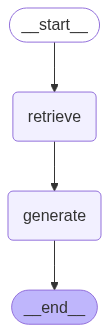

In [30]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
# result = graph.invoke({"question": "What is Task Decomposition?"})
result = graph.invoke({"question": "What is the attention mechanism?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='37c72b07-939c-45f5-a0b7-a5c4aef5b597', metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2024-04-10T21:11:43+00:00', 'author': '', 'keywords': '', 'moddate': '2024-04-10T21:11:43+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'title': '', 'trapped': '/False', 'source': './assets-resources/attention-paper.pdf', 'total_pages': 15, 'page': 1, 'page_label': '2', 'start_index': 2345}, page_content='in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes\nit more difficult to learn dependencies between distant positions [ 12]. In the Transformer this is\nreduced to a constant number of operations, albeit at the cost of reduced effective resolution due\nto averaging attention-weighted positions, an effect we counteract with Multi-Head Attention as\ndescribed in section 3.2.\nSelf-attention, sometimes ca

In [21]:
for step in graph.stream(
    {"question": "What are the main elements of an Agent?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='d27a7854-e0f1-4f19-86b1-37bce56d7f9c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 25955}, page_content="Prompt LM with 100 most recent observations and to generate 3 most salient high-level questions given a set of observations/statements. Then ask LM to answer those questions.\n\n\nPlanning & Reacting: translate the reflections and the environment information into actions\n\nPlanning is essentially in order to optimize believability at the moment vs in time.\nPrompt template: {Intro of an agent X}. Here is X's plan today in broad strokes: 1)\nRelationships between agents and observations of one agent by another are all taken into consideration for planning and reacting.\nEnvironment information is present in a tree structure.\n\n\n\n\n\nThe generative agent architecture. (Image source: Park et al. 2023)"), Document(id='8f09fa60-5c68-423e-b3bc-4f49e420f200', metadata={'source': 'https://lilianweng.gi